In [1]:
from mozo import my_train_test_split, train_and_submit, merge_with_features, from_ln_pln_trans_to_predict, num_to_range_categories, my_train_test_split, save_model, stratified_sample

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#%matplotlib inline

import math

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)


from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.svm import SVC

from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error

from scikitplot.estimators import plot_learning_curve

import seaborn as sns

import time
from datetime import datetime
from threading import Timer

import xgbfir


In [88]:
train = pd.read_hdf('output/newest_train.car_price.h5')
test = pd.read_hdf('output/newest_test.car_price.h5') #zbiór testowy bez odpowiedzi

# pomysly:
- startyfikacja
- waznosc cech
- zapomiane zmienne jak: EUR/PLN, Mazowieckie, 
- encodowanie -1 braków - zamiast sredniej, zera
- z bonusu waznosc kombijacji cech
- kombinacje na featurach
- kombinacje na innych
- hiper tuning
- w xgboost metryka uczenia log
- bread ???
- sztuczne zmienne jak trend ?

# Stratyfikacja:
- 

In [89]:
total = pd.concat([train, test], ignore_index=True)

In [92]:
for cl in total.columns:
    cl_new = cl.replace('-', '_')
    total.rename({cl: cl_new}, axis=1, inplace=True)


In [79]:
#train_30['car_id'].to_csv('output/split_train_30.csv', index=False) 
train_30 = pd.read_csv('~/pml7/konkurs/output/split_train_30.csv')
train_30

,car_id
0,65450
1,142125
2,56196
3,135963
4,29491
...,...
31947,81607
31948,109409
31949,159270
31950,84860


In [6]:
num_to_range_categories(train, 'price_value_pln', n_cat=10)

perc_60     11021
perc_40     10940
perc_80     10746
perc_90     10684
perc_20     10666
perc_00     10574
perc_10     10567
perc_70     10529
perc_50     10434
perc_30     10332
perc_100        1
Name: range_price_value_pln_cat, dtype: int64
['perc_00', 'perc_10', 'perc_100', 'perc_20', 'perc_30', 'perc_40', 'perc_50', 'perc_60', 'perc_70', 'perc_80', 'perc_90']
0


In [39]:
total.loc[total['range_price_value_pln_cat'] == 'perc_100', 'range_price_value_pln_cat'] = 'perc_90'
total['range_price_value_pln_cat'].value_counts()

perc_60    11021
perc_40    10940
perc_80    10746
perc_90    10685
perc_20    10666
perc_00    10574
perc_10    10567
perc_70    10529
perc_50    10434
perc_30    10332
Name: range_price_value_pln_cat, dtype: int64

In [33]:
#num_to_range_categories(total, 'new_param_rok-produkcji', n_cat=10) #20
num_to_range_categories(total, 'new_param_przebieg', n_cat=8) #30
total.loc[total['range_new_param_przebieg_cat'] == 'perc_100', 'range_new_param_przebieg_cat'] = 'perc_88'
total['range_new_param_przebieg_cat'].value_counts()

perc_62     13562
perc_75     13383
perc_25     13368
perc_12     13330
perc_88     13320
perc_00     13237
perc_50     13159
perc_38     13134
perc_100        1
Name: range_new_param_przebieg_cat, dtype: int64
['perc_00', 'perc_100', 'perc_12', 'perc_25', 'perc_38', 'perc_50', 'perc_62', 'perc_75', 'perc_88']
0


perc_62    13562
perc_75    13383
perc_25    13368
perc_12    13330
perc_88    13321
perc_00    13237
perc_50    13159
perc_38    13134
Name: range_new_param_przebieg_cat, dtype: int64

2656    -1.118164
95838    0.184900
78437    0.081634
55568   -1.025382
22678   -0.535017
           ...   
81142   -1.610640
33829   -0.676331
68670   -1.839482
78759   -0.439003
65478   -0.566516
Name: price_value_pln_log_transl, Length: 85195, dtype: float64

In [52]:
train, test = train_test_split(
    train.loc[:, train.columns != 'price_value_pln_log_transl'], 
    train['price_value_pln_log_transl'], 
    test_size=0.3, random_state=3785, shuffle=True, 
#                                stratify=train[[
#                                    'price_value'
#                                    #'encoded_seller_type', 
#                                    #'new_param_rok-produkcji',
#                                    #'new_param_przebieg'
#                                ]]
)

ValueError: too many values to unpack (expected 2)

# features

feats = test.select_dtypes(include=[np.number, np.bool]).columns
feats = feats[ feats != 'car_id' ].values
feats

In [80]:
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106494 entries, 0 to 106493
Columns: 348 entries, breadcrumb to range_price_value_pln_cat
dtypes: bool(88), float64(84), int64(77), object(99)
memory usage: 220.2+ MB


In [81]:
# Get a Dictionary containing the pairs of column names & data type objects.
dataTypeDict = dict(total.dtypes)
print('Data type of each column of Dataframe :')
print(dataTypeDict)


Data type of each column of Dataframe :
{'breadcrumb': dtype('O'), 'created_at': dtype('O'), 'price_currency': dtype('O'), 'price_details': dtype('O'), 'price_value': dtype('float64'), 'seller_address': dtype('O'), 'seller_name': dtype('O'), 'seller_type': dtype('O'), 'feature_czujniki_parkowania_przednie': dtype('bool'), 'feature_poduszka_powietrzna_chroniąca_kolana': dtype('bool'), 'feature_kurtyny_powietrzne': dtype('bool'), 'feature_klimatyzacja_dwustrefowa': dtype('bool'), 'feature_światła_led': dtype('bool'), 'feature_czujnik_zmierzchu': dtype('bool'), 'feature_elektrycznie_ustawiane_lusterka': dtype('bool'), 'feature_asr_(kontrola_trakcji)': dtype('bool'), 'feature_poduszka_powietrzna_kierowcy': dtype('bool'), 'feature_cd': dtype('bool'), 'feature_elektryczne_szyby_przednie': dtype('bool'), 'feature_poduszka_powietrzna_pasażera': dtype('bool'), 'feature_system_start_stop': dtype('bool'), 'feature_światła_do_jazdy_dziennej': dtype('bool'), 'feature_komputer_pokładowy': dtype('boo

In [98]:
total.loc[total['range_new_param_pojemność_skokowa_cat'] == 'perc_100', 'range_new_param_pojemność_skokowa_cat'] = 'perc_90'


In [ ]:
def plot_cat(df, var):
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title('Histogram')
    sns.countplot(df[var], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(var + ' vs Price')
    sns.boxplot(x=df[var], y=df['price_value_pln_log_transl'], palette=("cubehelix"))

    plt.show()



1: price_currency [100.00%=160616/160616]: 
PLN    160288
EUR       328
Name: price_currency, dtype: int64


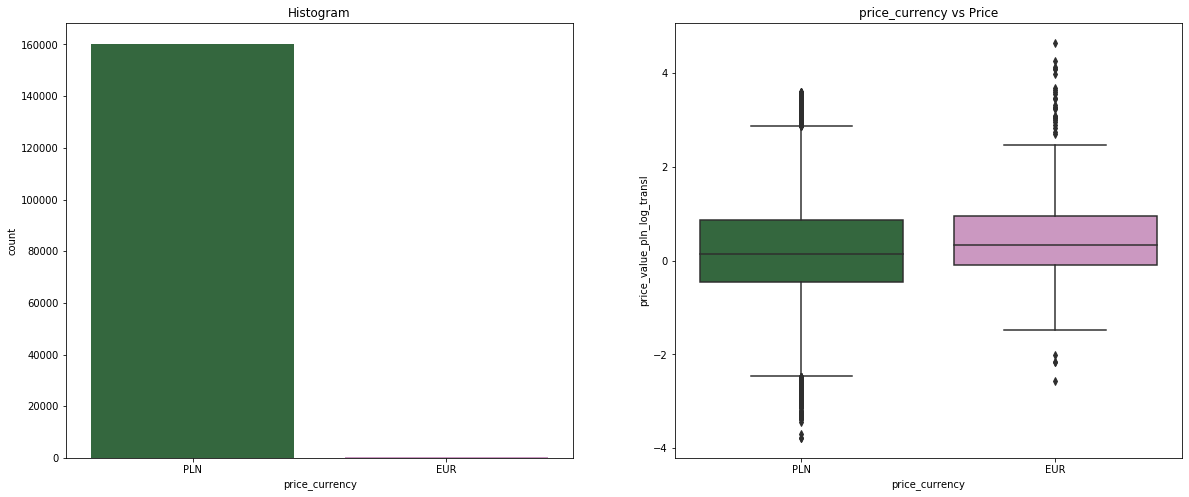

2: price_details [66.30%=106494/160616]: 
Cena Brutto, Do negocjacji                                                    49422
Cena Brutto                                                                   29148
Cena Brutto, Faktura VAT                                                      13781
Cena Brutto, Do negocjacji, Faktura VAT                                        7528
Cena Netto, Faktura VAT                                                        2828
Cena Netto, Do negocjacji, Faktura VAT                                         2277
Cena Netto                                                                      716
Cena Netto, Do negocjacji                                                       685
Brutto                                        , Do negocjacji                    51
Brutto                                                                           27
Brutto                    , Faktura VAT                    , Do negocjacji       10
Brutto                    , Faktur

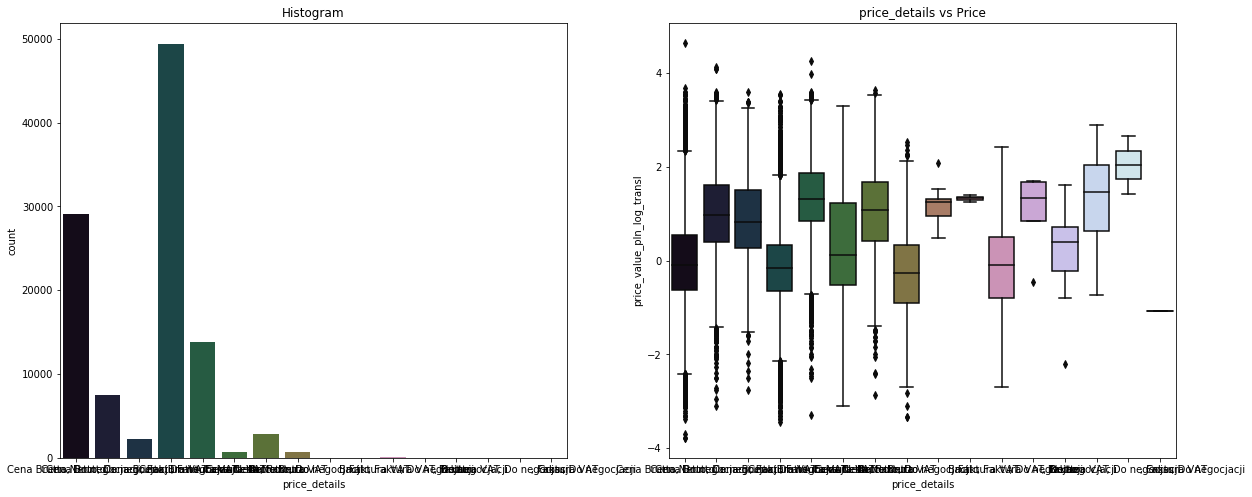

4: seller_address [99.90%=160455/160616]: 
5: seller_name [60.53%=97228/160616]: 
6: seller_type [99.90%=160455/160616]: 
Dealer            97228
Osoba prywatna    63227
Name: seller_type, dtype: int64


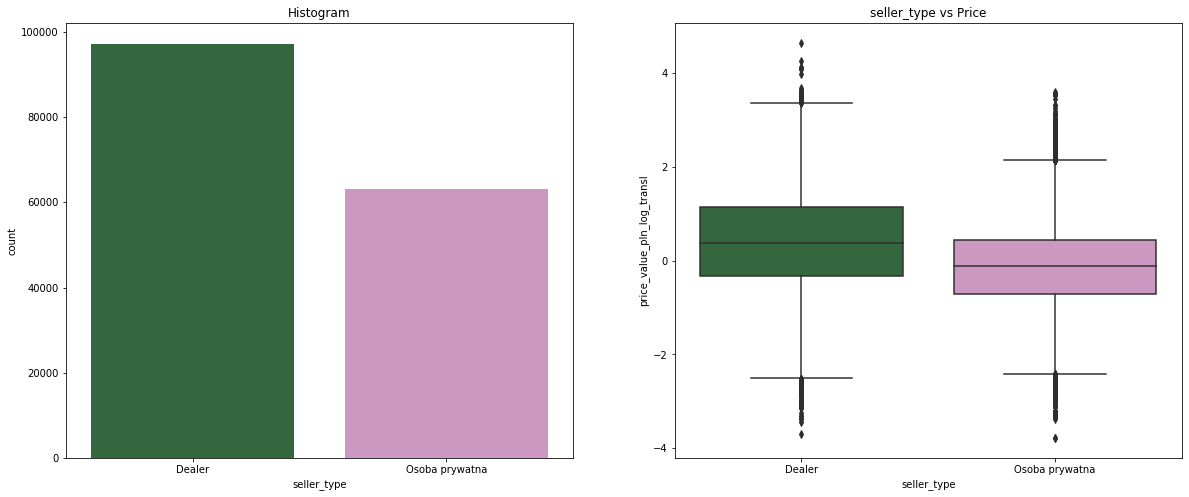

77: param_liczba_miejsc [88.76%=142559/160616]: 
5    123193
7      8118
4      7020
2      1711
9      1059
6       572
8       504
3       378
1         4
Name: param_liczba_miejsc, dtype: int64


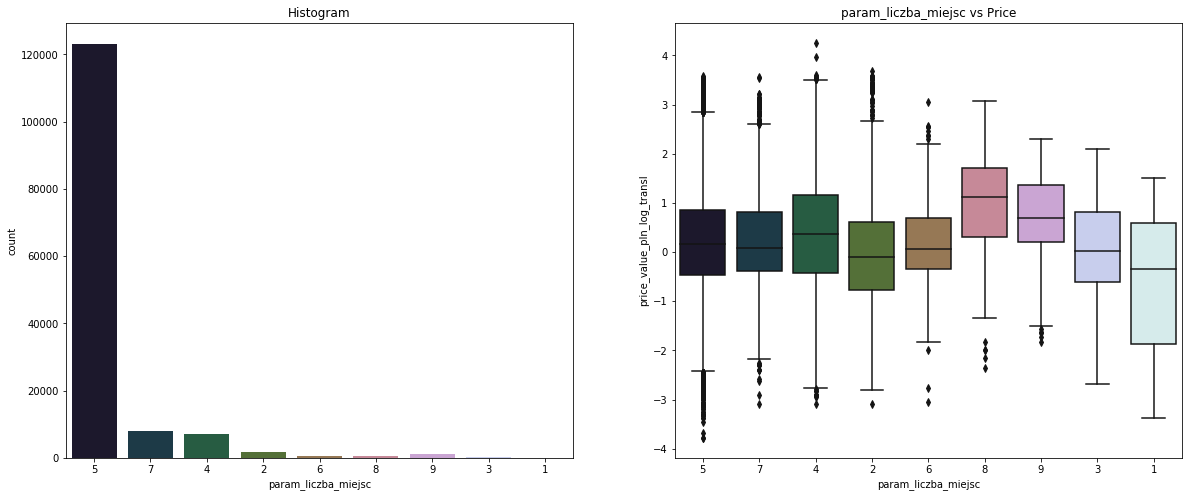

78: param_uszkodzony [3.97%=6384/160616]: 
79: param_marka_pojazdu [99.82%=160327/160616]: 
80: param_model [0.08%=128/160616]: 
81: param_engine_code [0.01%=14/160616]: 
82: param_liczba_drzwi [90.71%=145688/160616]: 
5     107713
4      22890
3      11021
2       3883
6        144
7         18
9          6
1          6
8          6
30         1
Name: param_liczba_drzwi, dtype: int64


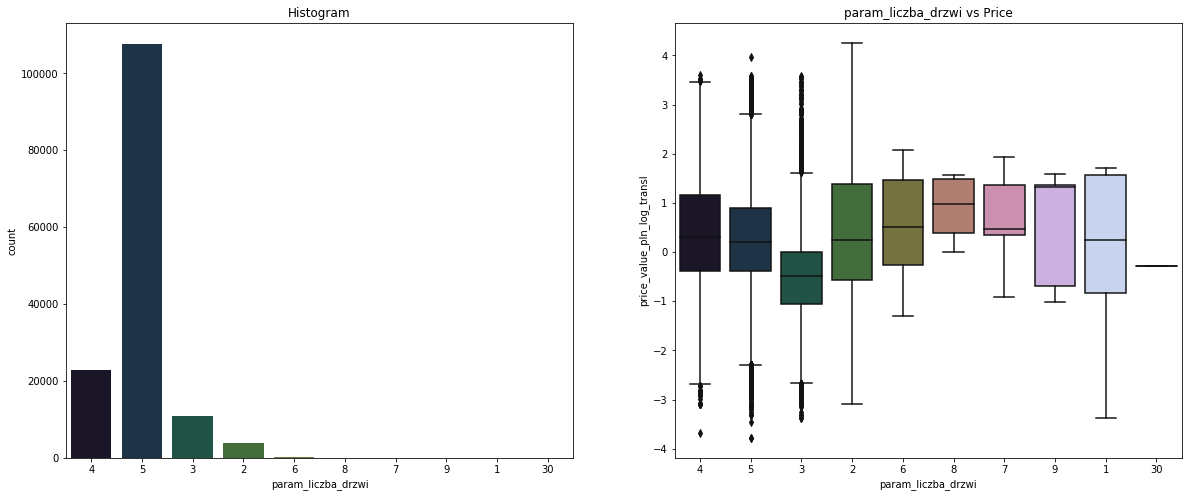

83: param_first_registration [0.03%=47/160616]: 
84: param_country_of_origin [0.05%=82/160616]: 
85: param_pierwsza_rejestracja [36.25%=58229/160616]: 
86: param_gearbox [0.08%=121/160616]: 
87: param_przebieg [99.58%=159945/160616]: 
88: param_faktura_vat [24.76%=39767/160616]: 
89: param_rok_produkcji [99.82%=160327/160616]: 
90: param_vin [22.23%=35701/160616]: 
91: param_perłowy [10.86%=17445/160616]: 
92: param_homologacja_ciężarowa [0.72%=1156/160616]: 
93: param_service_record [0.04%=65/160616]: 
94: param_metallic [0.05%=87/160616]: 
95: param_leasing_concession [0.01%=13/160616]: 
96: param_color [0.08%=128/160616]: 
97: param_financing_option [0.03%=44/160616]: 
98: param_original_owner [0.04%=58/160616]: 
99: param_vat_marża [33.99%=54587/160616]: 
100: param_kategoria [99.90%=160455/160616]: 
101: param_co2_emissions [0.00%=3/160616]: 
102: param_leasing [10.78%=17320/160616]: 
103: param_mileage [0.08%=127/160616]: 
104: param_zarejestrowany_jako_zabytek [0.08%=126/160616]

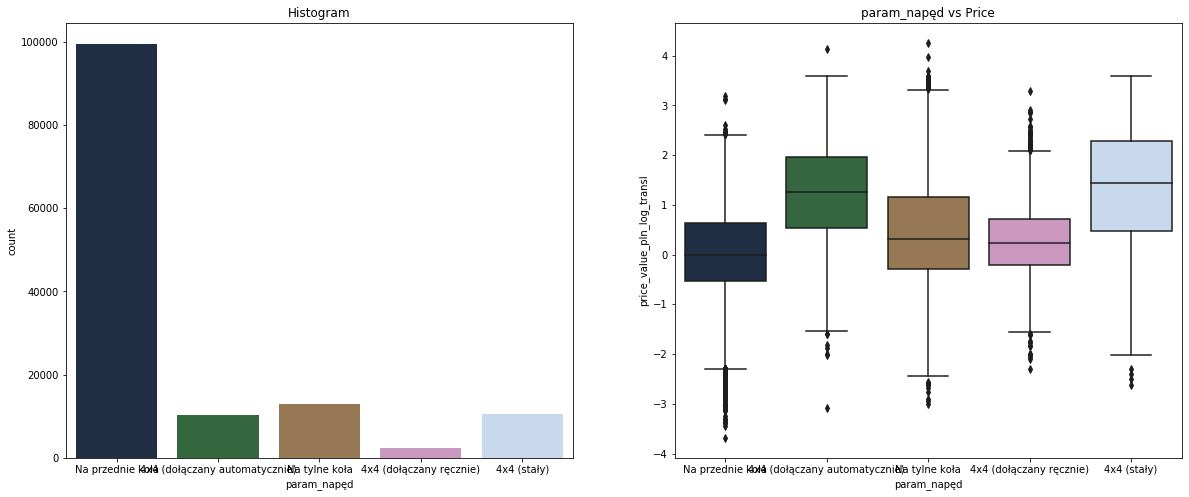

106: param_wartość_wykupu [0.25%=407/160616]: 
107: param_typ [99.82%=160326/160616]: 
Kombi                   32984
Sedan                   27024
Kompakt                 24843
SUV                     24249
Auta miejskie           20521
Minivan                 19764
Auta małe                5403
Coupe                    4009
Kabriolet                1347
sedan/coupe/cabrio         45
hatchback                  43
sedan/coupe                40
coupe/cabrio               37
minivan/city-car            6
city-car/suv                3
compact/minivan             3
coupe/cabrio/minivan        2
others                      1
compact/sedan               1
not enough details          1
Name: param_typ, dtype: int64


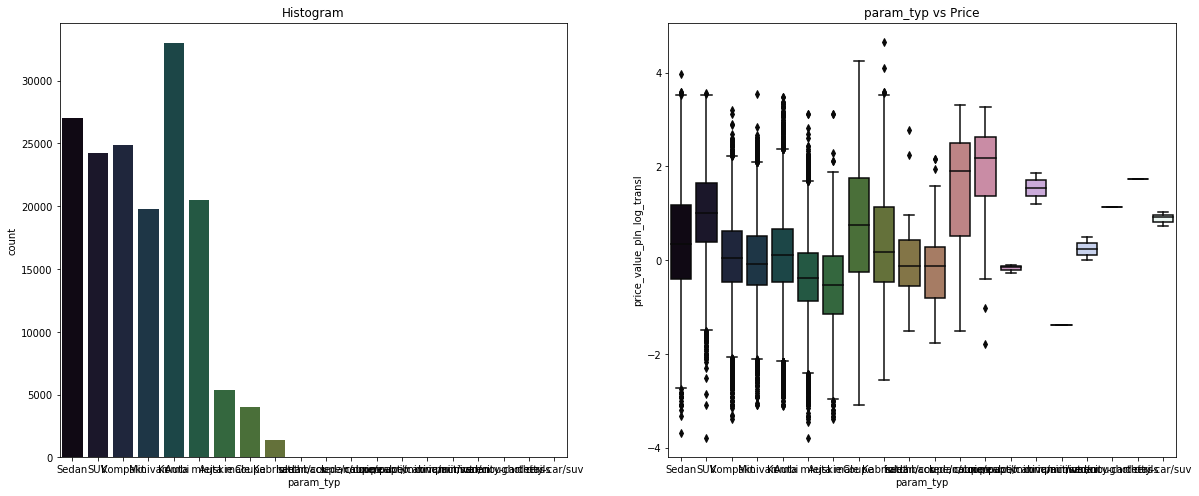

108: param_metalik [68.13%=109428/160616]: 
Tak         109400
metallic        28
Name: param_metalik, dtype: int64


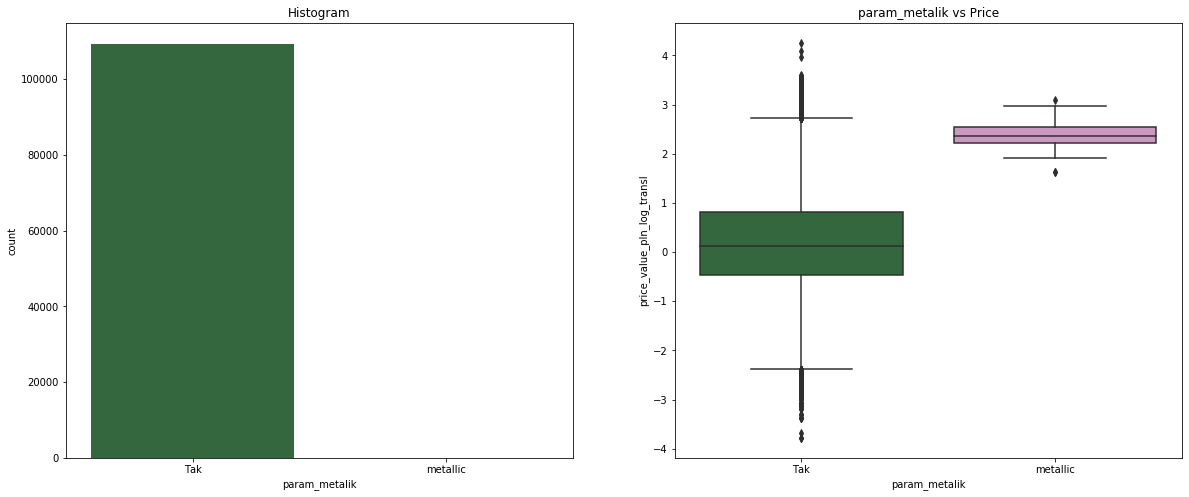

109: param_pierwszy_właściciel [44.24%=71051/160616]: 
110: param_skrzynia_biegów [94.48%=151750/160616]: 
Manualna                                 110590
Automatyczna hydrauliczna (klasyczna)     27935
Automatyczna dwusprzęgłowa (DCT, DSG)      9623
Automatyczna bezstopniowa (CVT)            2300
Półautomatyczna (ASG, Tiptronic)           1302
Name: param_skrzynia_biegów, dtype: int64


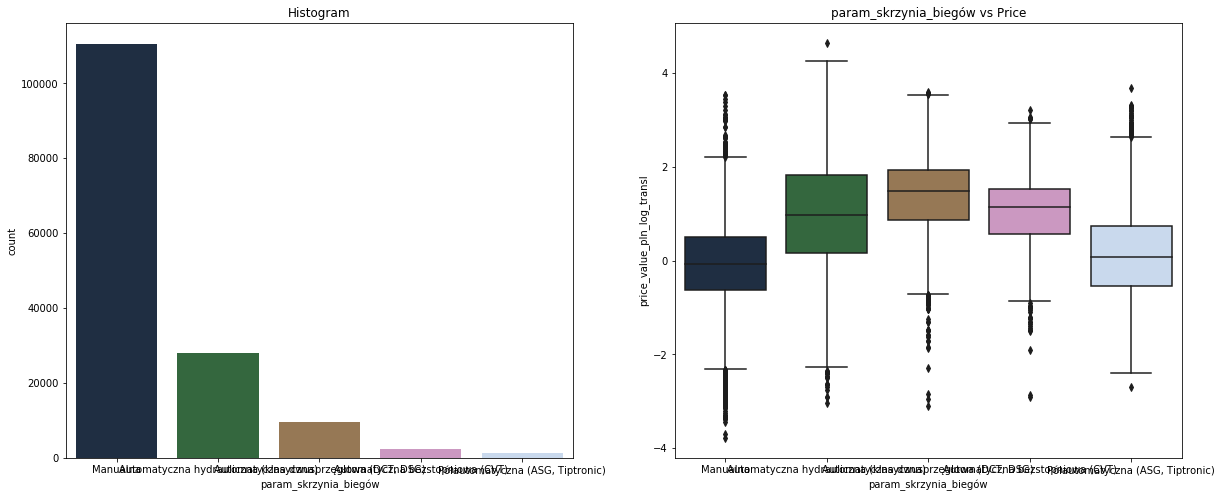

111: param_vat_discount [0.03%=42/160616]: 
112: param_no_accident [0.05%=77/160616]: 
113: param_liczba_pozostałych_rat [0.28%=442/160616]: 
114: param_particle_filter [0.01%=9/160616]: 
115: param_zarejestrowany_w_polsce [46.08%=74016/160616]: 
116: param_oferta_od [99.90%=160455/160616]: 
Firmy              97223
Osoby prywatnej    63232
Name: param_oferta_od, dtype: int64


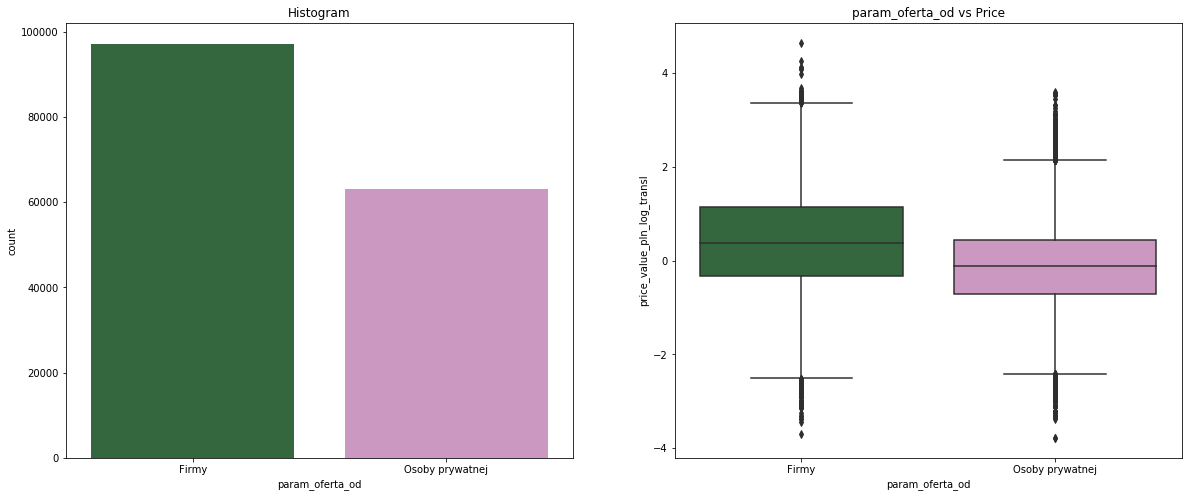

117: param_moc [91.11%=146331/160616]: 
118: param_make [0.08%=128/160616]: 
119: param_kraj_pochodzenia [67.96%=109150/160616]: 
120: param_engine_power [0.07%=115/160616]: 
121: param_year [0.08%=128/160616]: 
122: param_serwisowany_w_aso [49.21%=79045/160616]: 
123: param_rodzaj_paliwa [99.82%=160327/160616]: 
Diesel         81376
Benzyna        70578
Benzyna+LPG     7185
Hybryda          959
Elektryczny      125
Benzyna+CNG      102
Wodór              1
Etanol             1
Name: param_rodzaj_paliwa, dtype: int64


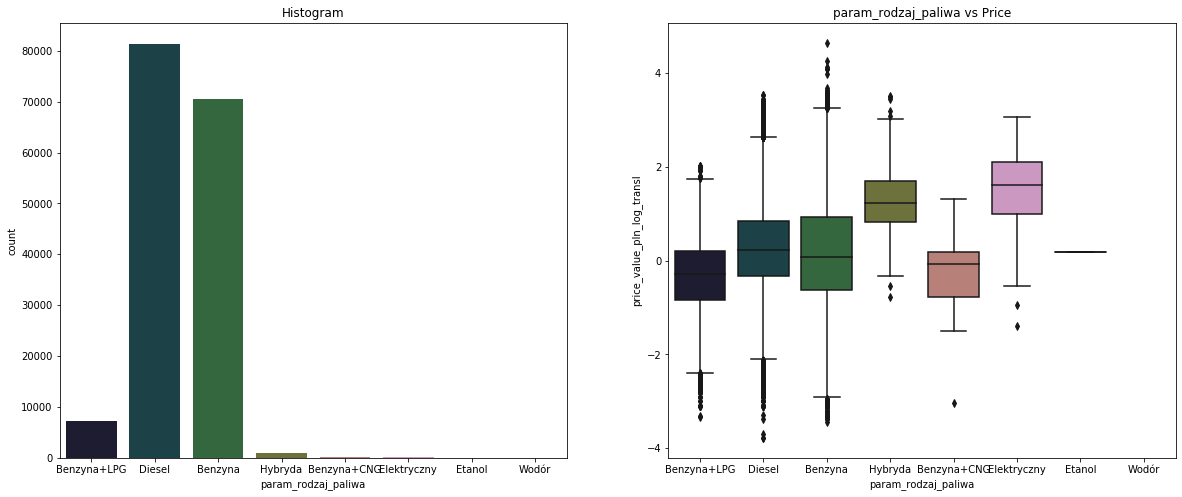

124: param_możliwość_finansowania [33.41%=53665/160616]: 
125: param_registered_in_poland [0.04%=58/160616]: 
126: param_transmission [0.07%=110/160616]: 
127: param_miesięczna_rata [0.45%=725/160616]: 
128: param_kod_silnika [10.74%=17251/160616]: 
129: param_version [0.06%=102/160616]: 
130: param_opłata_początkowa [0.26%=412/160616]: 
131: param_model_pojazdu [99.82%=160327/160616]: 
132: param_pojemność_skokowa [95.16%=152840/160616]: 
133: param_kierownica_po_prawej_(anglik) [0.72%=1163/160616]: 
134: param_fuel_type [0.08%=128/160616]: 
135: param_vat_free [0.02%=32/160616]: 
136: param_acrylic [0.00%=6/160616]: 
137: param_damaged [0.00%=6/160616]: 
138: param_door_count [0.07%=117/160616]: 
139: param_tuning [0.54%=874/160616]: 
140: param_filtr_cząstek_stałych [5.87%=9425/160616]: 
141: param_nr_of_seats [0.07%=113/160616]: 
142: param_kolor [99.82%=160327/160616]: 
Czarny        39242
Srebrny       29485
Szary         21909
Biały         17670
Niebieski     17415
Inny kolor  

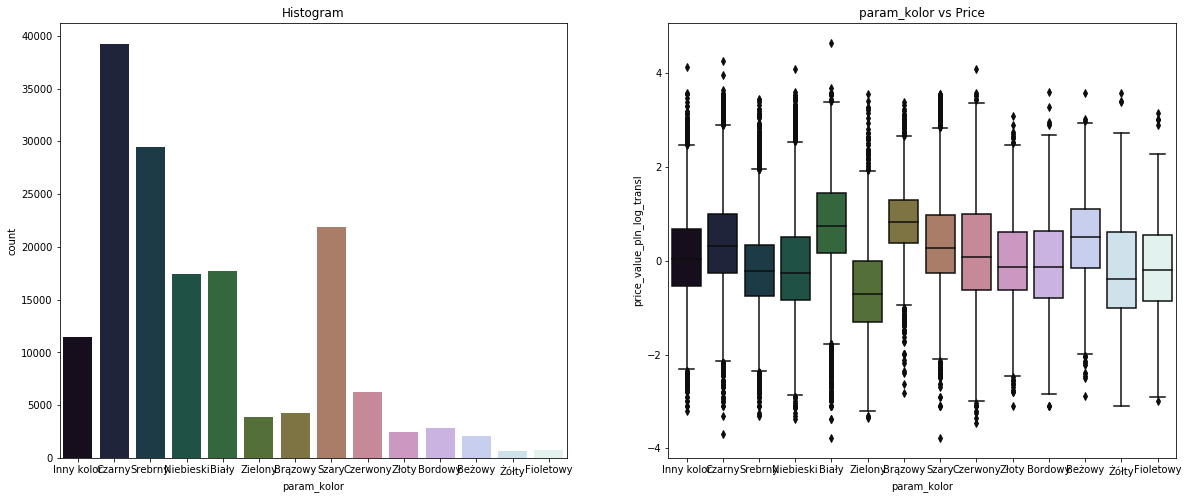

143: param_engine_capacity [0.08%=122/160616]: 
144: param_pearl [0.01%=12/160616]: 
145: param_stan [99.90%=160455/160616]: 
Używane    146217
Nowe        14238
Name: param_stan, dtype: int64


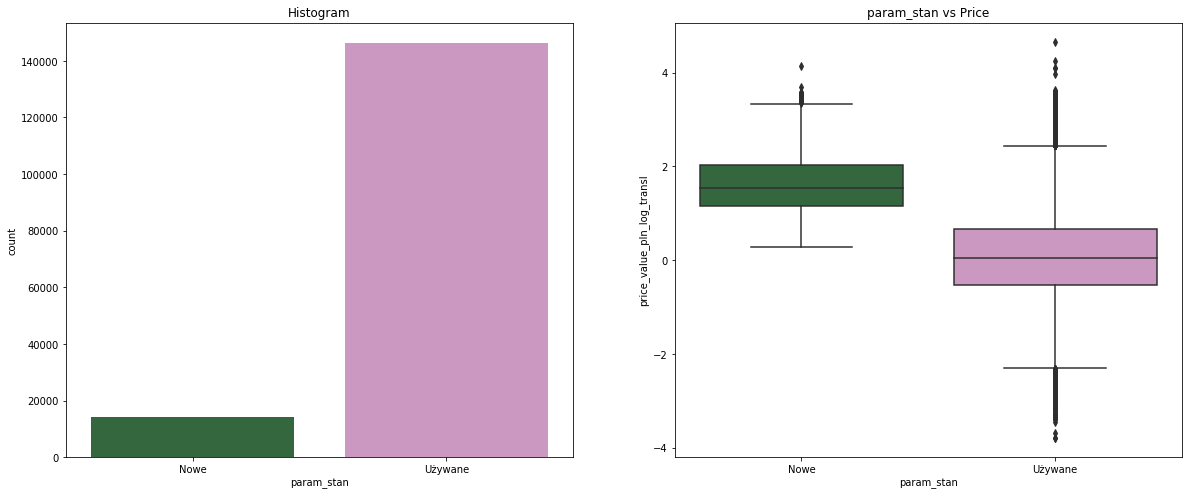

146: param_wersja [77.42%=124355/160616]: 
147: param_emisja_co2 [1.94%=3114/160616]: 
148: param_body_type [0.08%=128/160616]: 
149: param_matowy [0.31%=494/160616]: 
150: param_bezwypadkowy [62.65%=100625/160616]: 
151: param_akryl_(niemetalizowany) [3.82%=6137/160616]: 
152: param_monthly_payment_value [0.00%=2/160616]: 
200: new_param_typ [100.00%=160616/160616]: 
Kombi            33012
Sedan            27094
Kompakt          24865
SUV              24263
Auta miejskie    20535
Minivan          19793
Auta małe         5407
Coupe             4051
Kabriolet         1432
_Inne              164
Name: new_param_typ, dtype: int64


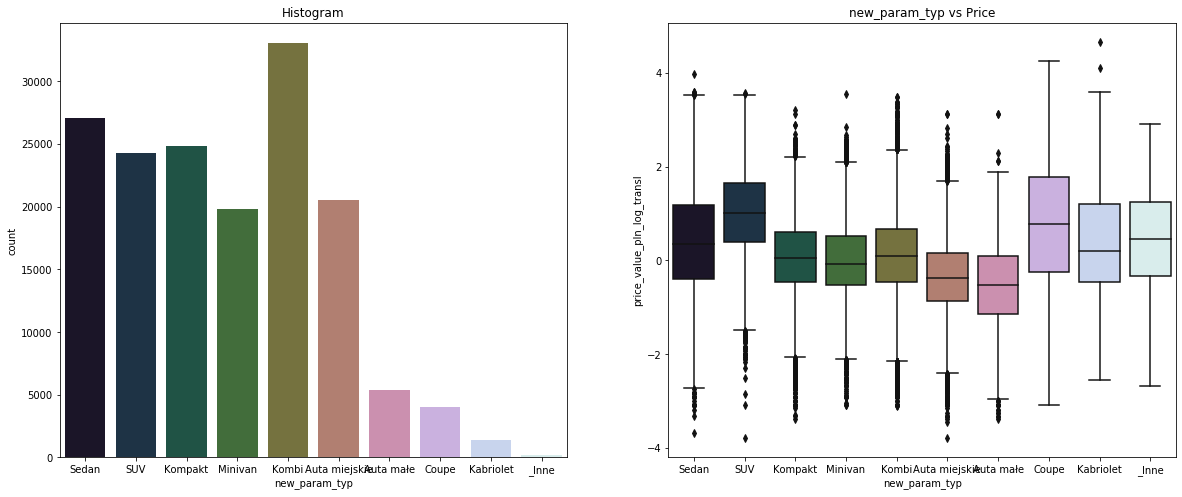

202: new_param_kraj_pochodzenia_2 [100.00%=160616/160616]: 
221: new_param_rodzaj_paliwa_2 [100.00%=160616/160616]: 
Diesel         81448
Benzyna        70793
Benzyna+LPG     7187
Hybryda          961
Elektryczny      125
Benzyna+CNG      102
Name: new_param_rodzaj_paliwa_2, dtype: int64


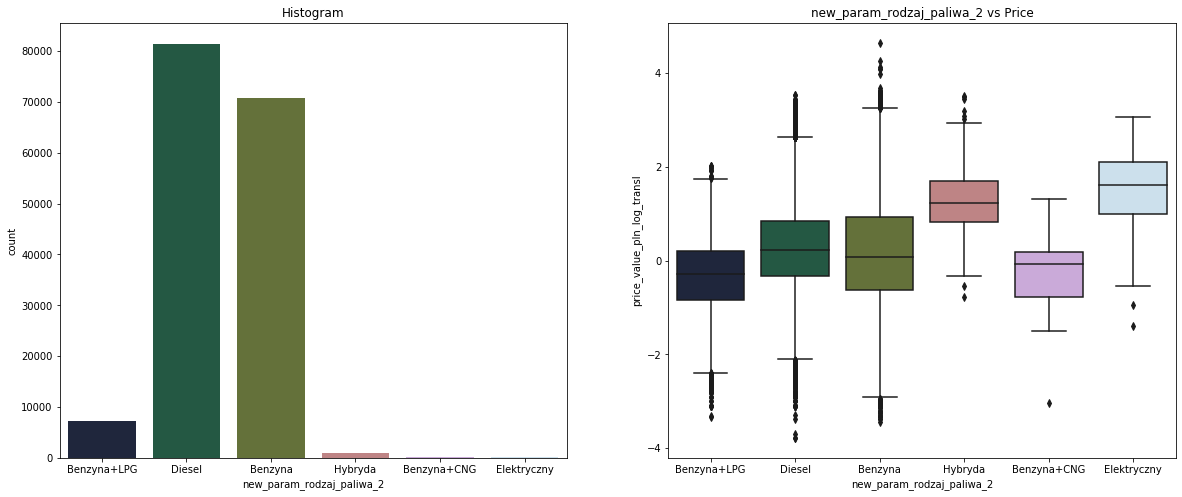

229: new_param_skrzynia_biegów_2 [100.00%=160616/160616]: 
Manualna                                 119426
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: new_param_skrzynia_biegów_2, dtype: int64


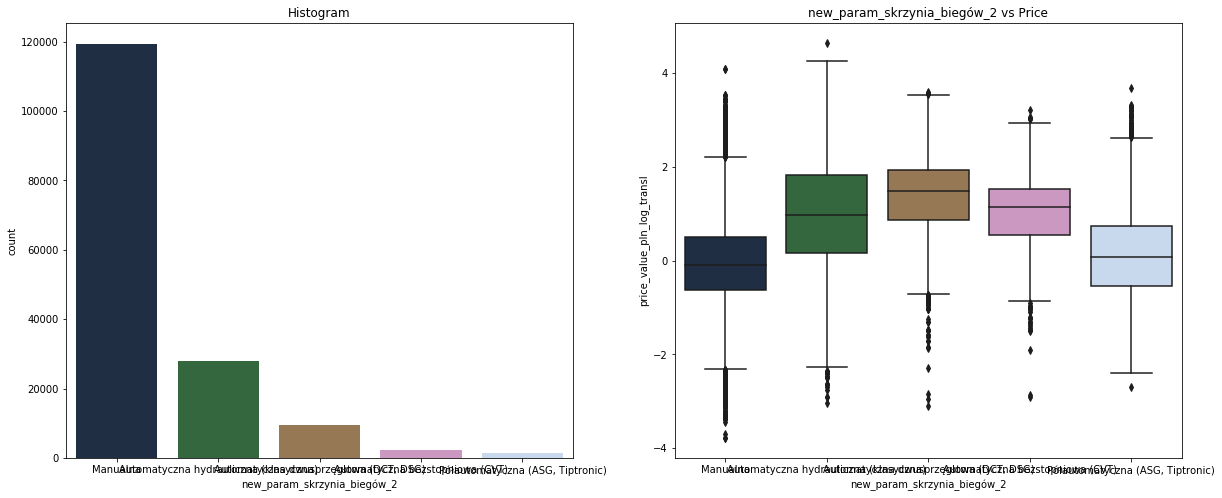

236: new_param_napęd_2 [100.00%=160616/160616]: 
Na przednie koła                 124243
Na tylne koła                     12967
4x4 (stały)                       10641
4x4 (dołączany automatycznie)     10341
4x4 (dołączany ręcznie)            2424
Name: new_param_napęd_2, dtype: int64


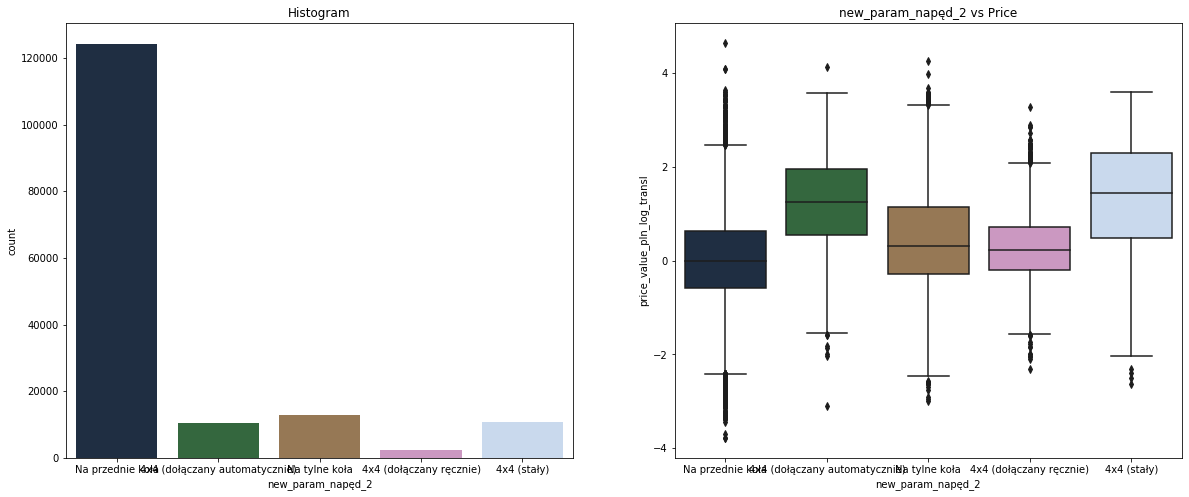

243: new_param_kolor_2 [100.00%=160616/160616]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11628
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
Name: new_param_kolor_2, dtype: int64


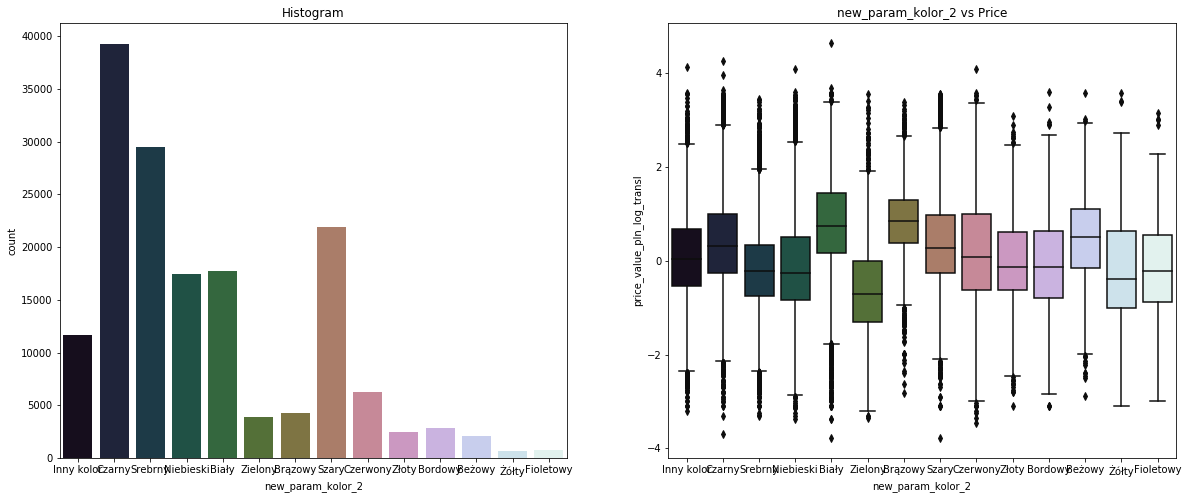

263: new_param_marka_pojazdu [66.24%=106385/160616]: 
265: new_param_model [66.24%=106385/160616]: 
267: new_param_wersja [51.42%=82583/160616]: 
269: new_param_kod_silnika [7.15%=11487/160616]: 
270: range_new_param_rok_produkcji_cat [100.00%=160616/160616]: 
perc_95     17673
perc_35     11310
perc_45     11066
perc_30     10390
perc_50      9619
perc_25      9292
perc_55      8881
perc_75      8726
perc_60      8271
perc_20      7904
perc_00      7670
perc_70      7597
perc_65      7509
perc_85      7187
perc_05      6554
perc_80      6458
perc_15      6112
perc_10      4855
perc_100     3542
Name: range_new_param_rok_produkcji_cat, dtype: int64


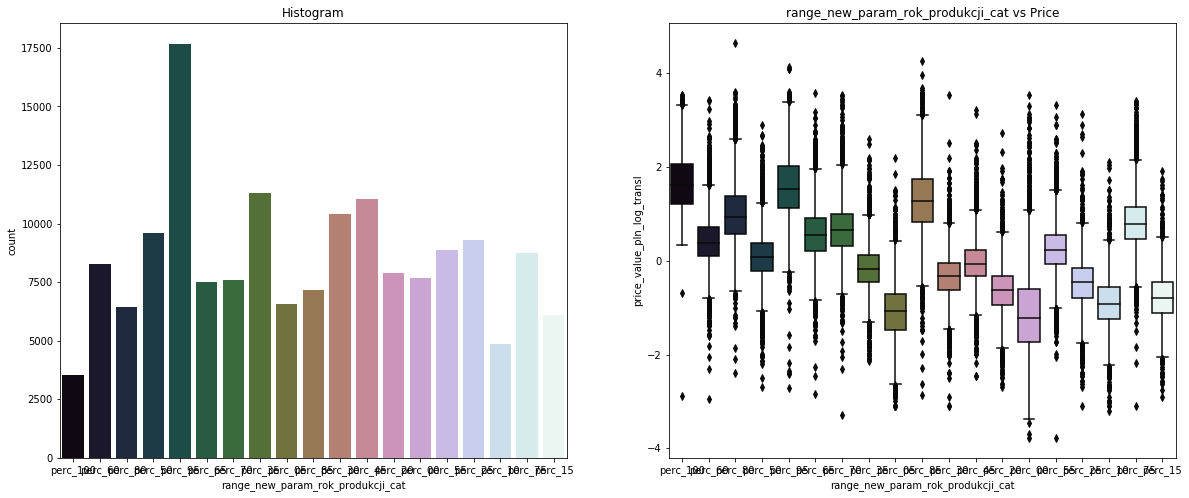

272: range_new_param_przebieg_cat [100.00%=160616/160616]: 
274: range_new_param_moc_cat [100.00%=160616/160616]: 
perc_53     23796
perc_73     17403
perc_13     12810
perc_87     12174
perc_20     11160
perc_40     11064
perc_07     10743
perc_80     10739
perc_93     10709
perc_60     10227
perc_27     10038
perc_33      8262
perc_00      8108
perc_67      3382
perc_100        1
Name: range_new_param_moc_cat, dtype: int64


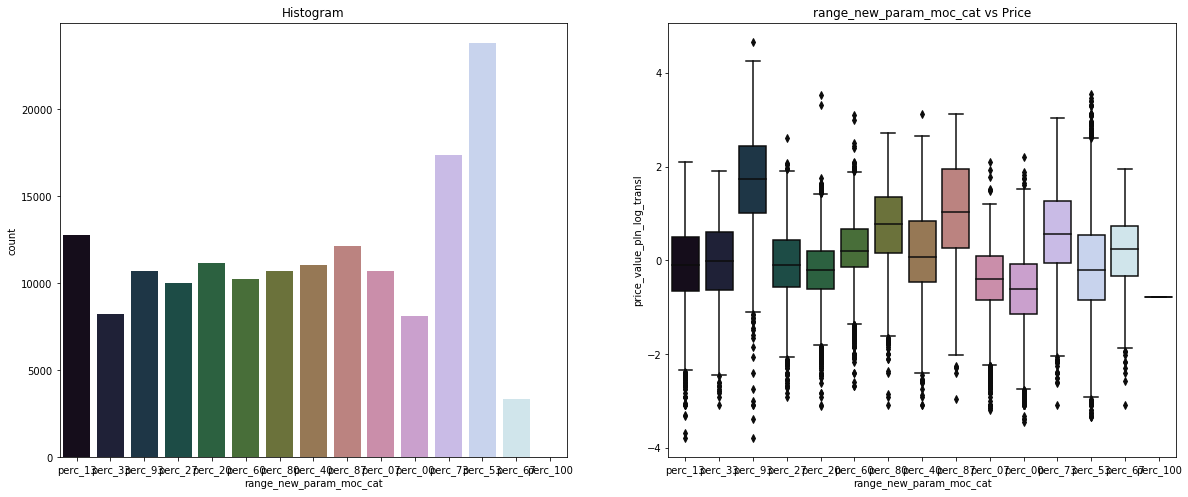

276: range_new_param_pojemność_skokowa_cat [100.00%=160616/160616]: 
perc_80    26722
perc_30    19748
perc_20    19184
perc_50    18045
perc_90    17446
perc_60    16588
perc_00    15952
perc_40    11974
perc_10     9185
perc_70     5772
Name: range_new_param_pojemność_skokowa_cat, dtype: int64


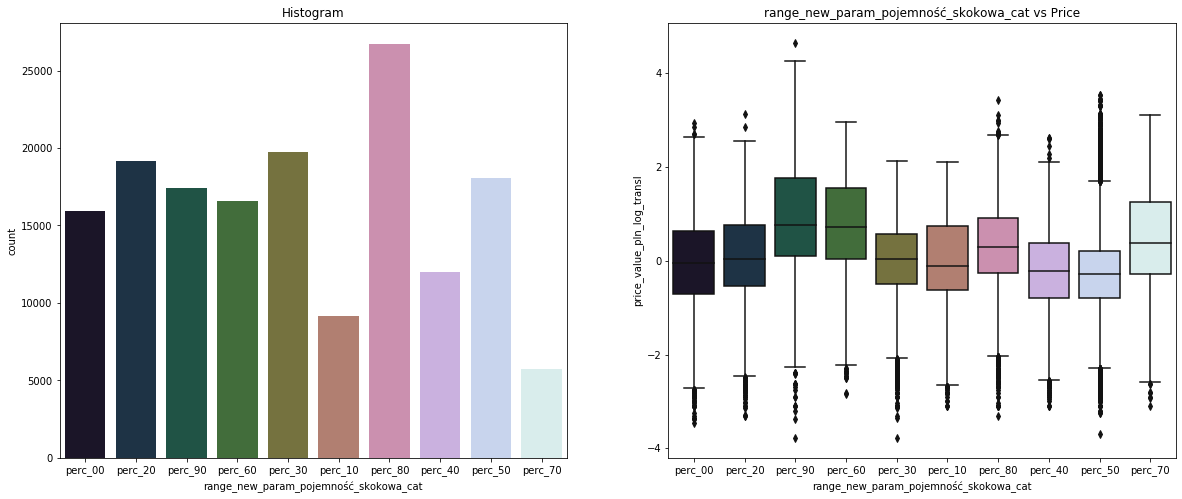

343: seller_wojewodzctwo [100.00%=160616/160616]: 
Mazowieckie            22620
Wielkopolskie          22125
-1                     19209
Śląskie                16155
Małopolskie            12155
Dolnośląskie           10411
Łódzkie                 9698
Pomorskie               7436
Lubelskie               7088
Kujawsko-pomorskie      6970
Podkarpackie            5105
Świętokrzyskie          5021
Zachodniopomorskie      4734
Warmińsko-Mazurskie     3767
Lubuskie                3229
Opolskie                2800
Podlaskie               2093
Name: seller_wojewodzctwo, dtype: int64


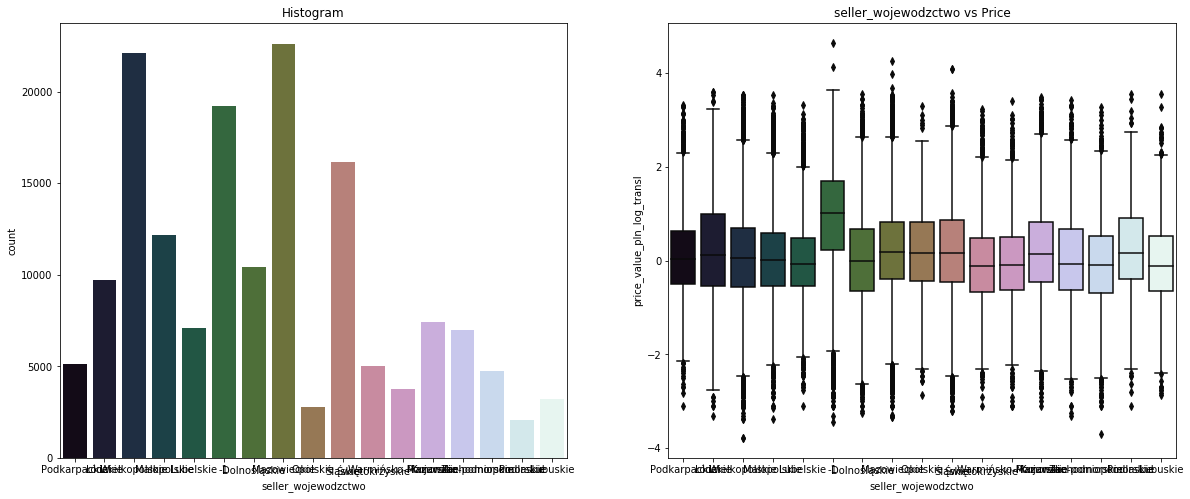

In [99]:
index = 0
for cl in total.columns[2:]:
    index += 1
    if total[cl].dtype == np.object:
#         print(cl)
        rows = len(total.index)
        nas = rows - total[cl].isna().sum()
        print(str(index) + ': ' + cl + " [{:.2f}%=".format(nas/rows*100) + str(nas) + '/' + str(rows) + ']: ')
        if nas/rows*100 > 9.0: 
            try:
                values = len(total[cl].value_counts())
                if 1 < values < 30:
                    print(total[cl].value_counts())
                    plot_cat(total, cl)
                    plt.clf()
                    plt.cla()
                    plt.close()
            except:
                i=0


In [ ]:
vars_main = [ 
             #'created_at_unix_na_mean', 
             'latitude_na_mean', 'longitude_na_mean', 
             'new_param_rok-produkcji', 
             #'new_param_rok_produkcji_minus_aktualny_rok', 
             #'new_param_pierwsza-rejestracja-date',
             'new_param_przebieg', 'new_param_moc', 'new_param_pojemność-skokowa', 
             #'new_param_liczba-drzwi', 'new_param_liczba-miejsc',
           ]

vars_features = [col for col in train if col.startswith('feature_')]

vars_bool_params = ['new_param_serwisowany-w-aso', 'new_param_pierwszy-właściciel', 'new_param_bezwypadkowy',
                'new_param_zarejestrowany-w-polsce',# 'new_param_uszkodzony', 
                'new_param_możliwość-finansowania','new_param_leasing-concession',
                #'new_param_filtr-cząstek-stałych',
                #'new_param_metalik', 'new_param_perłowy', 'new_param_akryl-(niemetalizowany)'
                   ]

vars_new_params_2 = [
    'encoded_new_param_typ', #'new_param_typ', 
              
    'encoded_new_param_kraj_pochodzenia', #'new_param_kraj_pochodzenia_2', 
    #'new_param_kraj_pochodzenia_Polska', 'new_param_kraj_pochodzenia_Niemcy', 'new_param_kraj_pochodzenia_Francja',     'new_param_kraj_pochodzenia_Belgia', 'new_param_kraj_pochodzenia_Szwajcaria', 'new_param_kraj_pochodzenia_Holandia',     'new_param_kraj_pochodzenia_Stany_Zjednoczone', 'new_param_kraj_pochodzenia_Włochy', 'new_param_kraj_pochodzenia_Austria',     'new_param_kraj_pochodzenia_Wielka_Brytania', 'new_param_kraj_pochodzenia_Dania', 'new_param_kraj_pochodzenia_Szwecja',     'new_param_kraj_pochodzenia_Luksemburg', 'new_param_kraj_pochodzenia_Kanada', 'new_param_kraj_pochodzenia_Czechy',      'new_param_kraj_pochodzenia_Hiszpania', 
    #'new_param_kraj_pochodzenia_Inny',
    
    'encoded_new_param_rodzaj_paliwa', #'new_param_rodzaj_paliwa_2',
    #'new_param_rodzaj_paliwa_Diesel', 'new_param_rodzaj_paliwa_Benzyna', 'new_param_rodzaj_paliwa_Benzyna_LPG',     'new_param_rodzaj_paliwa_Benzyna_CNG', 'new_param_rodzaj_paliwa_Hybryda', 'new_param_rodzaj_paliwa_Elektryczny',
    
    'encoded_new_param_skrzynia_biegów', #'new_param_skrzynia_biegów_2',  
    #'new_param_skrzynia_biegów_Manualna', 'new_param_skrzynia_biegów_Półautomatyczna', 'new_param_skrzynia_biegów_Automatyczna_hydrauliczna',     'new_param_skrzynia_biegów_Automatyczna_dwusprzęgłowa', 'new_param_skrzynia_biegów_Automatyczna_bezstopniowa',
    
    'encoded_new_param_napęd', #'new_param_napęd_2', 
    #'new_param_napęd_Na_przednie_koła', 'new_param_napęd_4x4_stały', 'new_param_napęd_4x4_dołączany_automatycznie',     'new_param_napęd_4x4_dołączany_ręcznie', 'new_param_napęd_Na_tylne_koła', 
              
    'encoded_new_param_kolor', #'new_param_kolor_2', 
    #'new_param_kolor_Beżowy',  'new_param_kolor_Biały',  'new_param_kolor_Bordowy',  'new_param_kolor_Brązowy',  'new_param_kolor_Czarny',  'new_param_kolor_Czerwony',  'new_param_kolor_Fioletowy',  'new_param_kolor_Inny kolor',  'new_param_kolor_Niebieski',  'new_param_kolor_Srebrny',  'new_param_kolor_Szary',  'new_param_kolor_Zielony',  'new_param_kolor_Złoty',  'new_param_kolor_Żółty', 
]

vars_new_params_3 = [
    'encoded_seller_type', #'encoded_seller_address', 
    'encoded_seller_name', 
              
    'encoded_new_param_marka_pojazdu', #'new_param_marka-pojazdu',
    'encoded_new_param_model_pojazdu', #'new_param_model',
    'encoded_new_param_wersja_pojazdu', #'new_param_wersja',
    'encoded_new_param_kod_silnika', #'new_param_kod-silnika',
             ]

vars_bool_years = [
           'new_param_pierwsza_rejestracja_ten_rok', 'new_param_pierwsza_rejestracja_poprzedni_rok', 'new_param_pierwsza_rejestracja_2_lata', 'new_param_pierwsza_rejestracja_3_lata',
           'new_param_pierwsza_rejestracja_4_5_lat', 'new_param_pierwsza_rejestracja_6_7_lat', 'new_param_pierwsza_rejestracja_8_10_lat', 'new_param_pierwsza_rejestracja_11_15_lat', 'new_param_pierwsza_rejestracja_16_wiecej_lat',
           
           'new_param_rok-produkcji_ten_rok', 'new_param_rok-produkcji_poprzedni_rok', 'new_param_rok-produkcji_2_lata', 'new_param_rok-produkcji_3_lata',
           'new_param_rok-produkcji_4_5_lat', 'new_param_rok-produkcji_6_7_lat', 'new_param_rok-produkcji_8_10_lat', 'new_param_rok-produkcji_11_15_lat', 'new_param_rok-produkcji_16_wiecej_lat',
]

vars_new_param_4 = [
    'encoded_seller_wojewodzctwo', #'seller_wojewodzctwo', 
    'percent_range_seller_wojewodzctwo'    
]

vars_mca = [col for col in train if col.startswith('mca_')]
vars_pca = [col for col in train if col.startswith('pca_')]


filter_col = [ 'car_id',
              *vars_main, 
              #*vars_features,  
              #*vars_bool_params,
              #*vars_new_params_2,
              #*vars_new_params_3,
              #*vars_new_param_4,
              #*vars_bool_years,
              *vars_mca,
              #*vars_pca,
             ] 


# print(train[filter_col].describe())
#print(train[filter_col].info())
#print(test[filter_col].info())
# (test[filter_col].head())

X_train, X_test, y_train, y_test = my_train_test_split(train[filter_col], train['price_value_pln_log_transl'], train_30)
#X_train, X_test, y_train, y_test = train_test_split(train[filter_col], train['price_value_pln_log_transl'], test_size=0.3)
#X_test.head()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

randfor = RandomForestClassifier()
randfor.fit(train[filter_col],train["price_value_pln_log_transl"])

skplt.estimators.plot_feature_importances(randfor, feature_names=feature_names, figsize=(9, 5))
plt.show()

In [ ]:
best_params =  {
    'n_estimators': 900, #879, 
    #'n_estimators': 879, 
    'learning_rate': 0.1, #0.017354274677292683, 
    #'learning_rate': 0.017354274677292683, 

    'subsample': 0.923403370465418,
    'colsample_bytree': 0.8797393544001986, 

    'max_depth': 10, #43, 
    #'max_depth': 43, 
    'min_child_weight': 100, #48, 
    #'min_child_weight': 48, 
    
    'reg_alpha': 1.1048264246167496, 
    'reg_lambda': 0.7451037079565321, 

    'random_state': 6950, 
    
}

#model = ctb.CatBoostRegressor(n_estimators=100, depth=10, random_state=3400, verbose=False)
#model = RandomForestRegressor(max_depth=10, n_estimators=150, max_features=0.8)
model = xgb.XGBRegressor(**best_params)

In [ ]:
mae, r2, model = train_and_submit(X_train, X_test, y_train, y_test, train, test, model, best_params,
                     file_sufix= 'z_funkcji', opis='testuje rozne n_estimators',
                     do_plot = False, save_min=8000,
                     kaggle=True, kaggle_min=7000) 

In [ ]:


feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh')
print(data)

In [ ]:
data.to_csv('output/ft_importance_'+datetime.now().strftime("%H:%M:%S")+'.csv', index=True)

In [ ]:




save_model(name='reczna_wrzuta', train_df=train, test_df=test,used_feats=X_train.columns, my_model=model, mae=mae, r2=r2, 
               details="Lepszy model z cechami wrzucaymi wg waznosci", plot_learning_curve = None, plt_hist = None, 
               kaggle=False)


In [1]:
!pip install --upgrade tables 

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tables in /home/conda/anaconda3/lib/python3.7/site-packages (3.6.1)


In [2]:
!cat /proc/cpuinfo


processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0x1
cpu MHz		: 2000.000
cache size	: 39424 KB
physical id	: 0
siblings	: 16
core id		: 0
cpu cores	: 8
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogom

In [3]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            58G        7.8G         49G        944K        1.1G         50G
Swap:            0B          0B          0B
